<a target="_blank" href="https://colab.research.google.com/github/dagworks-inc/burr/blob/main/examples/parallelism/notebook.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> 
or <a target="_blank" href="https://www.github.com/dagworks-inc/burr/tree/main/examples/parallelism/notebook.ipynb">view source</a>

In [ ]:
# install some dependencies and a few more
%pip install "burr[start,opentelemetry]" opentelemetry-instrumentation-openai openai anthropic

# Parallelism (& Recursion)

Burr is all about thinking and modeling things as a "graph" or "flowchart". This just so happens to be a great way to model agents. This modeling also lends itself well to modeling "recursion" and "parallelism", which are key in building more complex interactions and agent systems.

In this notebook we're going to go over how to run parallel "actions", which could be as simple as a single "action", or even "whole burr sub-applications themselves" (a.k.a. "sub-agents"). For full documentation on Parallelism see [this page](https://burr.dagworks.io/concepts/parallelism/); if you're familliar with the [`map-reduce`](https://en.wikipedia.org/wiki/MapReduce) pattern, then you'll feel right at home here.

We will start simple and show how to write a simple Burr application that compares different LLMs for the same prompt & context. We'll then extend what we parallelize to be a whole burr sub-application/agent. 

To start:
1. we will not use Burr's parallelism or recursion constructs to help build your mental model.
2. we will then show Burr's ["recursion" capabilities](https://burr.dagworks.io/concepts/recursion/).
3. we will then show how Burr's parallelism constructs simplify things.
4. we will then show how Burr's parallelism constructs enable you to more easily model more complex behavior.

Throughout we will show how the self-hostable Burr UI helps us capture telemetry and understand what's going on.

In [ ]:
# set your OpenAI API key
import os
os.environ["OPENAI_API_KEY"] = "..."

# Imports
What we need for this whole notebook

In [31]:
from concurrent.futures import ThreadPoolExecutor
from typing import Callable, Generator, List, Dict, Any

# for displaying in the notebook
from IPython.display import HTML, IFrame
import pprint
import openai

# burr imports
from burr.core import action, State, ApplicationBuilder, ApplicationContext, Action
from burr.core.parallelism import MapStates, RunnableGraph

# instrumentation using opentelemetry
from opentelemetry.instrumentation.openai import OpenAIInstrumentor
OpenAIInstrumentor().instrument()

Attempting to instrument while already instrumented


In [75]:
# let's load up some jupyter UI magics
%load_ext burr.integrations.notebook
%burr_ui  # this starts the UI in a background process

The burr.integrations.notebook extension is already loaded. To reload it, use:
  %reload_ext burr.integrations.notebook
Burr UI: http://127.0.0.1:7241


In [ ]:
# if in google collab we need to expose the port
from google.colab import output
# output.serve_kernel_port_as_iframe(7241) # can expose as an iframe directly
output.serve_kernel_port_as_window(7241) # can expose as a new tab -- take note of the URL and provide it below.

In [79]:
URL_FOR_UI = "http://localhost:7241" # this is the default -- replace with google collab domain (without trailing /)
# e.g. URL_FOR_UI = "https://cg2cjmb1mmu-496ff2e9c6d22116-7241-colab.googleusercontent.com"

# Actions

In this next code block we'll set up the base actions that we'll use to construct our Burr applications. That is, the things we'll want to run in parallel.

Our initial Burr application will have a simple (3-action/node) structure:

1. `process_input` -- pulls data in from the user at runtime
2. `run_llms` -- runs the different LLM models in parallel (not defined below)
3. `join_outputs` -- writes a map of LLM -> result

We will first define actions (1) and (3), then redefine (2) according to whether we're using recursion or parallelism.

In [77]:
def _query_llm(model: str, prompt: str) -> str:
    """Simple function to query our LLM -- we use OpenAI here / swap for your favorite model"""
    client = openai.Client()
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content


@action(reads=[], writes=["prompt", "models"])
def process_input(state: State, prompt: str, models: List[str]) -> State:
    """First Action (node) in our graph -- will take the prompt input and write to state"""
    return state.update(prompt=prompt, models=models)


@action(reads=["responses", "models"], writes=["all_responses"])
def join_outputs(state: State) -> State:
    """Final action (node), just joins in a dictionary"""
    joined_results = {}
    for response, model in zip(state["responses"], state["models"]):
        joined_results[model] = response
    return state.update(all_responses=joined_results)

# Approach #1 -- doing this manually

Nothing stops you from running multiple queries in the same Burr Action. In this we're going to just define the middle action to run in parallel -- it will launch an application in Burr, and wait for the results.

This is the "manual" approach -- how you might achieve parallelism without Burr. In it, we're going to do the following:

1. Create a Burr sub-application composed of a single action (node) that queries the LLM
2. Run multiple variants of it in parallel
3. Join the result

This is a useful approach as it is simple and looks like standard python code. That said, it lacks in visibility -- you have no way to know what the sub-LLM calls are doing.

First, we'll define the middle action. Next, we'll define the application. Then we can run!

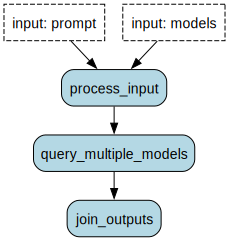

In [78]:
@action(reads=["models", "prompt"], writes=["responses"])
def query_multiple_models(state: State) -> State:
    """Query multiple models in parallel and store the results in the state."""
    models: List[str] = state["models"]
    prompt: str = state["prompt"]

    def query_model(model: str) -> str:
        return _query_llm(model, prompt)

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(query_model, model): model for model in models}
        results = {}
        for future in futures:
            model = futures[future]
            results[model] = future.result()
    
    return state.update(responses=results)

app = (
    ApplicationBuilder()
    .with_actions(
        process_input, # define in fircell above
        query_multiple_models,
        join_outputs
    ).with_entrypoint("process_input")
    .with_tracker(project="parallelism_example", use_otel_tracing=True)
    .with_transitions(
        ("process_input", "query_multiple_models"),
        ("query_multiple_models", "join_outputs")
    )
    .build()
)
app

In [80]:
# setup UI to see the run - hit the live button to see it run live
IFrame(f'{URL_FOR_UI}/project/parallelism_example/null/{app.uid}', width="100%", height="700px")

In [20]:
# let's run the application
action_, _, state = app.run(
    inputs={"prompt": "what is the meaning of life?", "models" : ["gpt-4", "gpt-4-turbo", "gpt-3.5-turbo"]},
    halt_after=["join_outputs"]
)

# Approach #2 -- using Burr within Burr, i.e. recursion

Burr allows you to create Burr applications within Burr applications and wire through tracking to the UI so you can visualize sub-applications. For this, we will be representing the LLM calls with different models as their own (single-node) application. While this is built for more complex sub-application shapes, and is a bit of overkill for our toy example, it still works quite well with the simplicity of a single action (node) application. My point here is that you could add more actions to the application very easily and do more complex operations than what we're doing here. The Burr sub-applications can be used independently elsewhere.

For more on the code constructs in this section see Burr's [recursive tracking capabilities](https://burr.dagworks.io/concepts/recursion/).

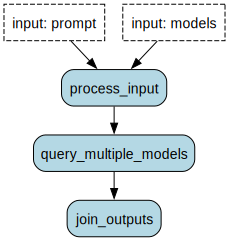

In [24]:
@action(reads=["model", "prompt"], writes=["response"])
def inner_query_model(state: State) -> State:
    return state.update(response=_query_llm(state["model"], state["prompt"]))
    
@action(reads=["models", "prompt"], writes=["responses"])
def query_multiple_models(state: State, __context: ApplicationContext) -> State:
    """Query multiple models in parallel and store the results in the state."""
    apps = []
    for model in state["models"]:
        sub_app = (# it's just a single action here, but it could be more!
            ApplicationBuilder()
                .with_actions(query_model=inner_query_model)
                .with_state(model=model, prompt=state["prompt"])
                .with_tracker(project="parallelism_example", use_otel_tracing=True)
                .with_spawning_parent(# we link the parent and subapplication together
                    app_id=__context.app_id,
                    sequence_id=__context.sequence_id
                )
                .with_entrypoint("query_model")
                .build()
        )
        apps.append((model, sub_app))
        
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(app.run, halt_after=["query_model"]): model for model, app in apps}
        results = {}
        for future in futures:
            model = futures[future]
            results[model] = future.result()
    
    return state.update(responses=results)

app_recursion = (
    ApplicationBuilder()
    .with_actions(
        process_input,
        query_multiple_models,
        join_outputs
    ).with_entrypoint("process_input")
    .with_tracker(project="parallelism_example", use_otel_tracing=True)
    .with_transitions(
        ("process_input", "query_multiple_models"),
        ("query_multiple_models", "join_outputs")
    )
    .build()
)
app_recursion

In [25]:
# hit the "live button" to see things run live
IFrame(f'{URL_FOR_UI}/project/parallelism_example/null/{app_recursion.uid}', width="100%", height="700px")

In [26]:
# let's run the application
action_, _, state = app_recursion.run(
    inputs={"prompt": "what is the meaning of life?", "models" : ["gpt-4", "gpt-4-turbo", "gpt-3.5-turbo"]},
    halt_after=["join_outputs"]
)

# Approach #3 -- using Burr's Parallel constructs

We can use Burr's parallel construct to make running the differnet LLMs in parallel even simpler. To do so we need to bring in a Class that extends from `MapStates` (we can also map over actions with [`MapActions`](https://burr.dagworks.io/reference/parallelism/#burr.core.parallelism.MapActions) and both state & actions with [`MapStateAndActions`](https://burr.dagworks.io/reference/parallelism/#burr.core.parallelism.MapActionsAndStates)). This Class enables us to "map" over state -- in this case, the Class will return the same Action for each model in the `models` field, enabling you to run the models in parallel. Underneath, Burr  will create the Burr Applications and run them in parallel. 

For more on the code constructs in this section see Burr's [parallel map/reduce concepts](https://burr.dagworks.io/concepts/parallelism/).

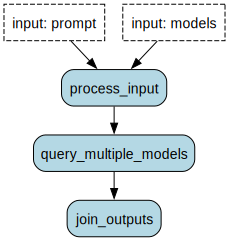

In [39]:
@action(reads=["model", "prompt"], writes=["response"])
def inner_query_model(state: State) -> State:
    return state.update(response=_query_llm(state["model"], state["prompt"]))
    
class RunOverMultiplePromptsAction(MapStates):
    """Our parallel action - defined as a class."""
    def states(
        self, state: State, context: ApplicationContext, inputs: Dict[str, Any]
    ) -> Generator[State, None, None]:
        """Generator to map over values in state"""
        for model in state["models"]:
            yield state.update(model=model)

    def action(self, state: State, inputs: Dict[str, Any]) -> Action:
        """The single action we want to map over"""
        return inner_query_model

    def reduce(self, state: State, results: Generator[State, None, None]) -> State:
        """The reduction step - allows us to customize how state is updated"""
        state = state.update(results=[])
        responses = {model: output_state["response"] for model, output_state in zip(state["models"], results)}
        return state.update(responses=responses)
            
    @property
    def reads(self) -> List[str]:
        """Like the function @action we need to specify what is read from state"""
        return ["models", "prompt"]

    @property
    def writes(self) -> List[str]:
        """Like the function @action we need to specify what is written to state"""
        return ["responses"]

app_parallelism = (
    ApplicationBuilder()
    .with_actions(
        process_input,
        join_outputs,
        query_multiple_models=RunOverMultiplePromptsAction(),
    ).with_entrypoint("process_input")
    .with_tracker(project="parallelism_example", use_otel_tracing=True)
    .with_transitions(
        ("process_input", "query_multiple_models"),
        ("query_multiple_models", "join_outputs")
    )
    .build()
)
app_parallelism

In [40]:
# hit the "live button" to see things run live
IFrame(f'{URL_FOR_UI}/project/parallelism_example/null/{app_parallelism.uid}', width="100%", height="700px")

In [41]:
# let's run the application
action_, _, state = app_parallelism.run(
    inputs={"prompt": "what is the meaning of life?", "models" : ["gpt-4", "gpt-4-turbo", "gpt-3.5-turbo"]},
    halt_after=["join_outputs"]
)

# #4 - Building more complex Burr Applications

Above we showed a progression on how you can tackle parallelism with Burr. Here we discuss and show sketches of examples that get more complex. Note: see [docs on executors](https://burr.dagworks.io/reference/application/#burr.core.application.ApplicationBuilder.with_parallel_executor) (and roadmap) as to what is supported right now.

For example, you might want to take the same input, and map over several Burr applications/agents in parallel, e.g. for medical diagnosis.
Or you might want to map over some value in state and run the same application/agent on it, e.g. web-interactions.
Lastly, you might want to do the cartesian product between values in state and actions

## Running parallel medical diagnoses
If you get a transcript + images of a medical situation. You want to run some hypotheses in parallel. How would you do that?

With Burr's parallel constructs, this would be a "map over actions", where "action" could be a simple action like above, or a full RAG agent. Below we sketch what the code would look like - using placeholder functions for core logic. 

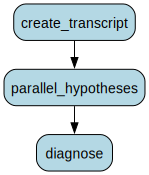

In [67]:
from burr.core import action, state, when
from burr.core.graph import GraphBuilder
from burr.core.parallelism import MapActions, RunnableGraph
from typing import Callable, Generator, List

# actions in our sub-graphs / sub-application / agent
@action(reads=["transcript"], writes=["query", "hypothesis"])
def hypothesis_1(state: State) -> State:
    _transcript = state["transcript"]
    # reads transcript, does  - and applies hypothesis 1
    return state.update(query=..., hypothesis=1)

@action(reads=["transcript"], writes=["query", "hypothesis"])
def hypothesis_2(state: State) -> State:
    _transcript = state["transcript"]
    # reads transcript, does  - and applies hypothesis 2
    return state.update(query=...,hypothesis=1)

@action(reads=["query"], writes=["context"])
def query(state: State) -> State:
    _query = state["query"]
    # does query against a datastore & gets context
    return state.update(context=...)

@action(reads=["context"], writes=["response"])
def llm_response(state:State) -> State:
    _context = state["context"]
    # does LLM call using context, i.e. the AG part of RAG.
    return state.update(response=...)

# graph 1 - or agent 1
hypothesis_graph_1 = RunnableGraph(
    graph=(
        GraphBuilder()
        .with_actions(
            hypothesis_1,
            query,
            llm_response
        )
        .with_transitions(
            ("hypothesis_1", "query"),
            ("query", "llm_response"),
        )
        .build()
    ),
    entrypoint="hypothesis_1",
    halt_after=["llm_response"],
)

# graph 2 - or agent 2
hypothesis_graph_2 = RunnableGraph(
    graph=(
        GraphBuilder()
        .with_actions(
            hypothesis_2,
            query,
            llm_response
        )
        .with_transitions(
            ("hypothesis_2", "query"),
            ("query", "llm_response"),
        )
        .build()
    ),
    entrypoint="hypothesis_2",
    halt_after=["llm_response"],
)

class RunMultipleGraphsAction(MapActions):
    """Our parallel action that will map over graphs"""

    def actions(self, state: State) -> Generator[Action | Callable | RunnableGraph, None, None]:
        """We hard code the actions here, but they could be dynamic"""
        for graph_action in [
            hypothesis_graph_1.with_name("hypothesis_1"),
            hypothesis_graph_2.with_name("hypothesis_2"),
        ]:
            yield graph_action

    def state(self, state: State) -> State:
        return state.update(transcript="this could be passed in or could be set here")

    def reduce(self, states: Generator[State, None, None]) -> State:
        # we aggregate here
        all_diagnoses = []
        for state in states:
            all_diagnoses.append((state["llm_response"], state["hypothesis"]))
        return state.update(all_diagnoses=all_diagnoses)
    
    @property
    def reads(self) -> List[str]:
        return ["transcript"]

    @property
    def writes(self) -> List[str]:
        return ["all_diagnoses"]

@action(reads=["audio"], writes=["transcript"])
def create_transcript(state: State) -> State:
    # create transcript
    return state.update(transcript=...)

@action(reads=["all_diagnoses"], writes=["diagnosis"])
def diagnose(state:State) -> State:
    # ... pick the best one
    return state.update(diagnosis=...)

map_actions_app = (
    ApplicationBuilder()
    .with_actions(
        create_transcript=create_transcript,
        parallel_hypotheses=RunMultipleGraphsAction(),
        diagnose=diagnose
    ).with_entrypoint("create_transcript")
    .with_tracker(project="parallelism_mapactions", use_otel_tracing=True)
    .with_transitions(
        ("create_transcript", "parallel_hypotheses"),
        ("parallel_hypotheses", "diagnose"),
    )
    .build()
)
map_actions_app

# To run it you'd do something like:
# action, result, state = map_actions_app.run(
#        halt_after=["diagnose"], inputs={...}
#    )

## Running parallel web interactions

Given a list of web-sites (or tasks), wouldn't it be great to process them in parallel?  Or perhaps you want to run some experiments over different inputs to your Burr application, this is one way to parallelize that, while keeping the original Burr application atomic and indpendently usable.

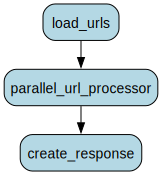

In [68]:
from burr.core import action, state, when
from burr.core.graph import GraphBuilder
from burr.core.parallelism import MapStates, RunnableGraph
from typing import Callable, Generator, List

# actions in our sub-graphs / sub-application / agent
@action(reads=["url"], writes=["data"])
def crawler(state: State) -> State:
    _url = state["url"]
    # goes to the URL and extracts something...
    return state.update(data=...)

@action(reads=["data"], writes=["summary"])
def summarize(state: State) -> State:
    _data = state["data"]
    # summarizes the data
    return state.update(summary=...)

@action(reads=["summary", "url"], writes=["classification"])
def classify_and_store(state: State) -> State:
    _context = state["summary"]
    _url = state["url"]
    # store data somewhere? or classify it? ... use your imagination here
    return state.update(classification=...)

# sub graph 1 - or agent 1
url_processor = RunnableGraph(
    graph=(
        GraphBuilder()
        .with_actions(
            crawler,
            summarize,
            classify_and_store
        )
        .with_transitions(
            ("crawler", "summarize"),
            ("summarize", "classify_and_store"),
        )
        .build()
    ),
    entrypoint="crawler",
    halt_after=["classify_and_store"],
)


class MapOverURLsAction(MapStates):
    """Our parallel action that will map over state values"""

    def action(self, state: State) -> Generator[Action | Callable | RunnableGraph, None, None]:
        """Return the one action."""
        return url_processor

    def states(
        self, state: State, context: ApplicationContext, inputs: Dict[str, Any]
    ) -> Generator[State, None, None]:
        """Generator to map over values in state"""
        for url in state["urls"]:
            yield state.update(url=url)

    def reduce(self, states: Generator[State, None, None]) -> State:
        # we aggregate here
        all_results = []
        for state in states:
            all_results.append((state["classification"], state["url"]))
        return state.update(all_results=all_results)
    
    @property
    def reads(self) -> List[str]:
        return ["urls"]

    @property
    def writes(self) -> List[str]:
        return ["all_results"]

@action(reads=["..."], writes=["urls"])
def load_urls(state: State) -> State:
    # create transcript
    return state.update(urls=...)

@action(reads=["all_results"], writes=["response"])
def create_response(state:State) -> State:
    # ... return results ...
    return state.update(response=...)

map_states_app = (
    ApplicationBuilder()
    .with_actions(
        load_urls=load_urls,
        parallel_url_processor=MapOverURLsAction(),
        create_response=create_response
    ).with_entrypoint("load_urls")
    .with_tracker(project="parallelism_mapstates", use_otel_tracing=True)
    .with_transitions(
        ("load_urls", "parallel_url_processor"),
        ("parallel_url_processor", "create_response"),
    )
    .build()
)
map_states_app

# To run it you'd do something like:
# action, result, state = map_states_app.run(
#        halt_after=["create_response"], inputs={...}
#    )


## Running "hyperparameter tuning": i.e. experiments over parameters of an agent (e.g. prompt), RAG systems (e.g. embeddings), etc.

Optimizations, hyperparameter tuning, or more simply figuring out what prompts, LLM model, and parameters to use, is an exercise that can be parallelized. With this new functionality, you could can invoke and run different sets of parameters / inputs over different Burr applications. You can then use the results of which to make more informed decisions as to what set of parameters, or what conditions lead to better or worse outcomes. 

Below we sketch the structure of how you could use the MapStateAndActions to achieve this using Actions (which is trivial to swap out for whole Burr graphs).

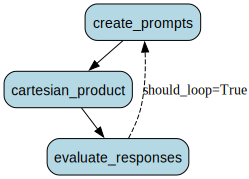

In [59]:
from burr.core import action, state, when
from burr.core.parallelism import MapActionsAndStates, RunnableGraph
from typing import Callable, Generator, List
import openai
import anthropic

@action(reads=["prompt"], writes=["llm_output"])
def query_llm_openai(state: State) -> State:
    """openai action"""
    prompt = state["prompt"]
    client = openai.Client()
    response = client.chat.completions.create(
        model="gpt4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    llm_output = response.choices[0].message.content
    return state.update(llm_output=(llm_output, "openai"))

@action(reads=["prompt"], writes=["llm_output"])
def query_llm_claude(state: State, model: str) -> State:
    """claude action"""
    prompt = state["prompt"]
    client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
        api_key="my_api_key",
    )
    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1024,
        messages=[{"role": "user", "content": prompt}]
    )
    return state.update(llm_output=(message.content, "anthropic"))

# def query_llm_ollama(...)

class TestModelsOverPromptsAction(MapActionsAndStates):
    """This is our aciton that will create a cartesian product over the states and actions returned.

    E.g. states x actions burr subapplications will be run in parallel.
    """

    def actions(self, state: State) -> Generator[Action | Callable | RunnableGraph, None, None]:
        # make sure to add a name to the action
        # This is not necessary for subgraphs, as actions will already have names
        for action in [
            query_llm_openai.with_name("openai"),
            query_llm_claude.with_name("claude"),
            #query_llm_ollama.with_name("ollama"),
        ]:
            yield action

    def states(self, state: State) -> Generator[State, None, None]:
        for prompt in state["prompts"]:
            yield state.update(prompt=prompt)

    def reduce(self, states: Generator[State, None, None]) -> State:
        all_llm_outputs = []
        for state in states:
            all_llm_outputs.append(
                {
                    "output" : state["llm_output"][0],
                    "provider" : state["llm_output"][1],
                    "prompt" : state["prompt"],
                }
            )
        return state.update(all_llm_outputs=all_llm_outputs)

    @property
    def reads(self) -> List[str]:
        return ["prompts"]

    @property
    def writes(self) -> List[str]:
        return ["all_llm_outputs"]

@action(reads=["best_one"], writes=["prompts"])
def create_prompts(state: State) -> State:
    """action that comes up with prompts - here we hard code for the example, but it could be dynamic."""
    prompts = [
            "What is the meaning of life?",
            "What is the airspeed velocity of an unladen swallow?",
            "What is the best way to cook a steak?",
        ]
    return state.update(prompts=prompts)

@action(reads=["all_llm_outputs"], writes=["best_one"])
def evaluate_responses(state: State) -> State:
    # some code here...
    return state.update(best_one=..., should_loop=...)
    

map_actions_and_state_app = (
    ApplicationBuilder()
    .with_actions(
        create_prompts=create_prompts,
        cartesian_product=TestModelsOverPromptsAction(),
        evaluate_responses=evaluate_responses
    ).with_entrypoint("create_prompts")
    .with_tracker(project="parallelism_mapstateandactions", use_otel_tracing=True)
    .with_transitions(
        ("create_prompts", "cartesian_product"),
        ("cartesian_product", "evaluate_responses"),
        ("evaluate_responses", "create_prompts", when(should_loop=True)),
    )
    .build()
)
map_actions_and_state_app

# To run it you'd do something like:
# action, result, state = map_actions_and_state_app.run(
#        halt_after=["evaluate_responses"], inputs={...}
#    )

# To close
We're excited by what you can now model and importantly observe & iterate with Burr + the Burr UI (e.g. see [test-case creation](https://burr.dagworks.io/examples/guardrails/creating_tests/), [time-travel](https://blog.dagworks.io/p/travel-back-in-time-with-burr), or [annotation](https://blog.dagworks.io/p/annotating-data-in-burr?r=2cg5z1&utm_campaign=post&utm_medium=web)). 

We have an active roadmap planned (we're looking for contributors!), and if you like what you see, have thoughts / or questions, please drop by our discord community -> [![Discord](https://img.shields.io/badge/Join-Burr_Discord-7289DA?logo=discord)](https://discord.gg/6Zy2DwP4f3)